In [57]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F


class Quantize(autograd.Function):
    @staticmethod
    def forward(ctx, input, n_bits=8, a=None, b=None):
        if a is None or b is None:
            a = input.min()
            b = input.max()
            ctx.save_for_backward(None, None)
        else:
            ctx.save_for_backward(a - input.min(), b - input.max())
        scale = (b - a) / (2 ** (n_bits - 1) - 1)
        return input.clamp(min=a, max=b).sub(a).div(scale).round().mul(scale).add(a)

    @staticmethod
    def backward(ctx, grad_output):
        grad_a, grad_b = ctx.saved_tensors
        return grad_output, None, grad_a, grad_b


class DTReLU(nn.Module):
    def __init__(self, n_bits=8):
        super().__init__()
        self.n_bits = n_bits
        self.lb = nn.parameter.Parameter(torch.zeros(1))
        self.ub = nn.parameter.Parameter(torch.ones(1))

    def forward(self, x):
        return Quantize.apply(F.relu(x), self.n_bits, self.lb, self.ub) * (x > 0)


In [58]:
# From https://github.com/MrGoriay/pwlu-pytorch/blob/main/PWLA.py
class PWLA2d(torch.nn.Module):
    """Piecewise Linear activation function for a 2 Dimensional data (B,C,L)
    from paper: https://arxiv.org/pdf/2104.03693.pdf
    Args:
        N = int - number of intervals contained in function
        momentum = float - strength of momentum during the statistics collection phase (Phase I in paper)
    """

    def __init__(self, N=16, momentum=0.9):
        super(PWLA2d, self).__init__()
        self.N = N
        self.momentum = momentum
        self.Br = nn.parameter.Parameter(torch.tensor(10.0))
        self.Bl = nn.parameter.Parameter(torch.tensor(-10.0))
        self.register_buffer("running_mean", torch.zeros(1))
        self.register_buffer("running_var", torch.ones(1))
        self.Kl = nn.parameter.Parameter(torch.tensor(0.0))
        self.Kr = nn.parameter.Parameter(torch.tensor(1.0))
        self.Yidx = nn.parameter.Parameter(
            F.relu(torch.linspace(self.Bl.item(), self.Br.item(), self.N + 1))
        )
        self.reset_parameters()

    def reset_parameters(self):
        self.running_mean.zero_()
        self.running_var.fill_(1)

    def forward(self, x):
        if self.training:
            mean = x.mean([0, 1, -1])  # {TODO}: Possibly split along channel axis
            var = x.var([0, 1, -1])  # {TODO}: Possibly split along channel axis
            self.running_mean = (self.momentum * self.running_mean) + (
                1.0 - self.momentum
            ) * mean  # .to(input.device)
            self.running_var = (self.momentum * self.running_var) + (
                1.0 - self.momentum
            ) * (x.shape[0] / (x.shape[0] - 1) * var)
            return F.relu(x)
        else:
            d = (self.Br - self.Bl) / self.N  # Interval length
            DATAind = torch.clamp(
                torch.floor((x - self.Bl.item()) / d), 0, self.N - 1
            )  # Number of corresponding interval for X
            Bdata = self.Bl + DATAind * d  # LEFT Interval boundaries
            maskBl = x < self.Bl  # Mask for LEFT boundary
            maskBr = x >= self.Br  # Mask for RIGHT boundary
            maskOther = ~(maskBl + maskBr)  # Mask for INSIDE boundaries
            Ydata = self.Yidx[DATAind.type(torch.int64)]  # Y-value for data
            Kdata = (
                self.Yidx[(DATAind).type(torch.int64) + 1]
                - self.Yidx[DATAind.type(torch.int64)]
            ) / d  # SLOPE for data
            return (
                maskBl * ((x - self.Bl) * self.Kl + self.Yidx[0])
                + maskBr * ((x - self.Br) * self.Kr + self.Yidx[-1])
                + maskOther * ((x - Bdata) * Kdata + Ydata)
            )

    def set_parameters(self):
        self.Bl.data = self.running_mean - 3 * self.running_var
        self.Br.data = self.running_mean + 3 * self.running_var
        self.Kl.data = torch.tensor(0.0)
        self.Kr.data = torch.tensor(1.0)
        self.training = False


In [59]:
# Incorrect implementation
class Dynamic_ReLu(nn.Module):
    def __init__(self, bits=4):
        super().__init__()
        self.bits = bits
        self.thres = nn.parameter.Parameter(
            torch.sort(torch.abs(torch.arange(1, 2**bits) / (2**bits - 1))).values
        )

    def forward(self, x):
        l = 2**self.bits - 1
        threshs = self.thres.sort().values
        output = torch.zeros_like(x)
        # Here every boolean mask cannot pass gradient to the thresholds
        # So no update for the thresholds actually happens
        output[x < threshs[0]] = 0.0
        for i in range(1, l - 1):
            # The only gradient for thresholds is from assignment
            mask = torch.logical_and(x < threshs[i + 1], x > threshs[i])
            output = output + mask * (
                (threshs[i] + threshs[i + 1]) / 2 + x - x.detach()
            )
        output[x >= threshs[-1]] = threshs[-1]
        return output


In [60]:
class DynamicAct(autograd.Function):
    # Fast dynamic relu
    # True dynamic thresholds
    @staticmethod
    def forward(ctx, input, threshs):
        # Make sure in order for indexing
        threshs_sort = threshs.sort().values.clamp(min=0)
        # Expand to input shape plus thresh shape
        thresh_mat = threshs_sort.expand(*input.shape, *threshs_sort.shape).permute(
            input.dim(), *tuple(range(input.dim()))
        )

        # Find the index of the right-most thresh that is less than input
        # And get the output from the index
        output = torch.concat([torch.zeros(1).to(input.device), threshs_sort])[
            (input >= thresh_mat).sum(dim=0)
        ]
        ctx.save_for_backward(output, threshs, input.max())
        return output

    @staticmethod
    def backward(ctx, grad_output):
        output, threshs, i_max = ctx.saved_tensors
        # Get the possible output values in order
        threshs_sort = torch.concat(
            [torch.zeros(1).to(grad_output.device), threshs.sort().values]
        )
        # partial derivative of the output with respect to the input
        grad_input = grad_output.clone()
        grad_input[output == threshs_sort[-1]] = 0
        grad_input[output == 0] = 0
        # partial derivative of the output with respect to the thresh
        # Count the thresholds in the output
        t, c = output.unique(return_counts=True)
        # Fill in zeroes for the thresholds that are not in the output
        c = torch.tensor(
            [
                c[(t == ths).float().argmax()] if ths in t else 0.0
                for ths in threshs_sort
            ]
        ).to(grad_output.device)
        # The gradient on the thresh is the right bin count minus the left bin count
        # And return in the same order as the original threshs
        grad_thresh = (c[:-1] - c[1:])[threshs.argsort().argsort()].float() / 2
        grad_thresh += grad_thresh * (threshs < 0)
        grad_thresh += grad_thresh * (threshs - i_max > 0)
        return grad_input, grad_thresh


class DDTReLU(nn.Module):
    def __init__(self, n_bits=8):
        super().__init__()
        self.threshs = nn.parameter.Parameter(
            torch.arange(1, 2**n_bits) / (2**n_bits - 1)
        )

    def forward(self, x):
        return DynamicAct.apply(x, self.threshs)


In [61]:
import time

import numpy as np

mean_val = 3 / 2
std_val = 1 / 2

model1 = Dynamic_ReLu(bits=4)
model2 = PWLA2d(N=2**4)
model3 = DTReLU(n_bits=4)
model4 = DDTReLU(n_bits=4)
model1.train()
model2.train()
model3.train()
model4.train()
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.001)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.001)
optimizer3 = torch.optim.SGD(model3.parameters(), lr=0.001)
optimizer4 = torch.optim.SGD(model4.parameters(), lr=0.001)
timer1 = [0]
timer2 = [0]
timer3 = [0]
timer4 = [0]
for i in range(3000):
    x = torch.normal(mean=mean_val, std=std_val, size=(10, 10, 10), requires_grad=True)
    for m, o, t in zip(
        [model1, model2, model3, model4],
        [optimizer1, optimizer2, optimizer3, optimizer4],
        [timer1, timer2, timer3, timer4],
    ):
        start = time.time()
        y = m(x)
        t[0] += float(time.time() - start)
        loss = (
            (y - (F.relu(x) + torch.normal(mean=0, std=std_val * 2, size=x.shape))) ** 2
        ).sum()
        o.zero_grad()
        loss.backward()
        o.step()

model2.set_parameters()

time_ag_scale1 = []
time_ag_scale2 = []
time_ag_scale3 = []
time_ag_scale4 = []

for s in range(1, 10 + 1):
    x = torch.normal(mean=mean_val, std=std_val, size=(s, s, s), requires_grad=True)
    for m, t in zip(
        [model1, model2, model3, model4],
        [time_ag_scale1, time_ag_scale2, time_ag_scale3, time_ag_scale4],
    ):
        t_tmp = []
        for _ in range(100):
            start = time.time()
            y = m(x)
            t_tmp.append(float(time.time() - start))
        t.append(t_tmp)

time_ag_scale1 = np.array(time_ag_scale1)
time_ag_scale2 = np.array(time_ag_scale2)
time_ag_scale3 = np.array(time_ag_scale3)
time_ag_scale4 = np.array(time_ag_scale4)


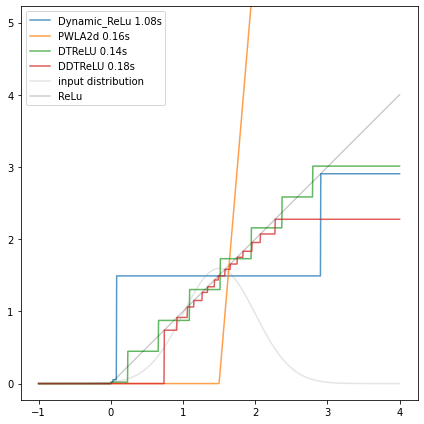

In [62]:
import matplotlib.pyplot as plt
from scipy import stats


fig = plt.figure(figsize=(6, 6))
x = torch.linspace(-1, 4, 1000)
x_dist = stats.norm.pdf(x.detach().cpu().numpy(), loc=mean_val, scale=std_val) * 2
x_relu = F.relu(x)
y = model1(x)
plt.plot(x.tolist(), y.tolist(), alpha=0.75, label=f"Dynamic_ReLu {timer1[0]:.2f}s")
y = model2(x)
plt.plot(x.tolist(), y.tolist(), alpha=0.75, label=f"PWLA2d {timer2[0]:.2f}s")
y = model3(x)
plt.plot(x.tolist(), y.tolist(), alpha=0.75, label=f"DTReLU {timer3[0]:.2f}s")
y = model4(x)
plt.plot(x.tolist(), y.tolist(), alpha=0.75, label=f"DDTReLU {timer4[0]:.2f}s")
plt.plot(x, x_dist, alpha=0.2, color="tab:grey", label="input distribution")
plt.plot(x, x_relu, alpha=0.2, color="black", label="ReLu")
plt.legend()
plt.axis("equal")
plt.ylim(0, 5)
plt.tight_layout()
plt.savefig("./fig/DynamicActivationResult.pdf")
plt.show()


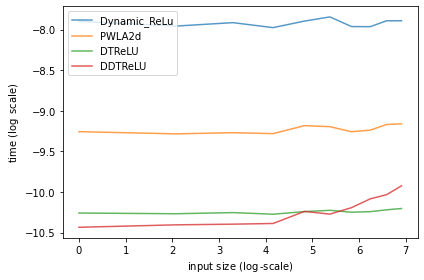

In [63]:
fig = plt.figure(figsize=(6, 4))
plt.plot(
    np.log(np.arange(1, 10 + 1) ** 3),
    np.log(time_ag_scale1.mean(axis=1)),
    label=f"Dynamic_ReLu",
    alpha=0.75,
)
plt.plot(
    np.log(np.arange(1, 10 + 1) ** 3),
    np.log(time_ag_scale2.mean(axis=1)),
    label=f"PWLA2d",
    alpha=0.75,
)
plt.plot(
    np.log(np.arange(1, 10 + 1) ** 3),
    np.log(time_ag_scale3.mean(axis=1)),
    label=f"DTReLU",
    alpha=0.75,
)
plt.plot(
    np.log(np.arange(1, 10 + 1) ** 3),
    np.log(time_ag_scale4.mean(axis=1)),
    label=f"DDTReLU",
    alpha=0.75,
)
plt.legend()
plt.xlabel("input size ($\\log$-scale)")
plt.ylabel("time ($\\log$ scale)")
plt.tight_layout()
plt.savefig('./fig/DynamicActivationTimeCost.pdf')
plt.show()
